In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import re
import string

In [2]:
# Load datasets
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [3]:
# Add labels
fake_df["label"] = 0   # Fake News
true_df["label"] = 1   # True News

In [4]:
print(fake_df.shape, true_df.shape)

(23481, 5) (21417, 5)


In [5]:
# Combine datasets
data = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [6]:
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
# Drop unnecessary columns
data = data.drop(columns=["title", "subject", "date"], errors="ignore")


In [8]:
# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\w*\d\w*", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["text"] = data["text"].astype(str).apply(clean_text)


In [9]:
# Train/Test Split
X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [10]:
# Feature extraction ---
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
# Train models

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(max_depth=100, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    results[name] = classification_report(y_test, preds, output_dict=True)
    print(f"🔹 {name}\n", classification_report(y_test, preds))

🔹 Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5871
           1       0.98      0.98      0.98      5354

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225

🔹 Decision Tree
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5871
           1       1.00      1.00      1.00      5354

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

🔹 Random Forest
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5871
           1       0.98      0.99      0.98      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg     

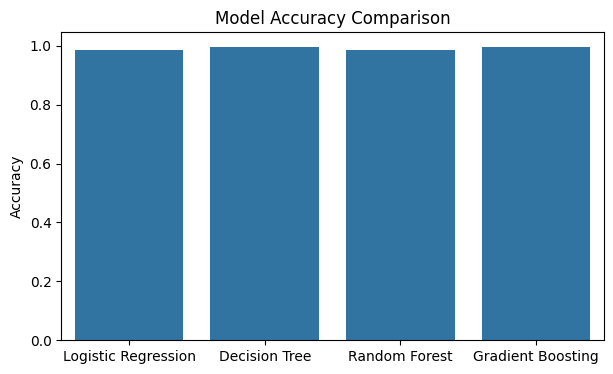

In [12]:
# Compare accuracy visually
acc_scores = {name: round(metrics["accuracy"], 3) for name, metrics in results.items()}

plt.figure(figsize=(7,4))
sns.barplot(x=list(acc_scores.keys()), y=list(acc_scores.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

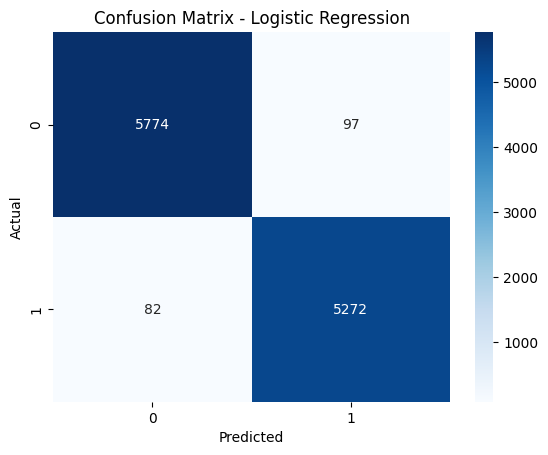

In [13]:
# Confusion Matrix (for best model)
best_model = LogisticRegression(max_iter=200)
best_model.fit(X_train_vec, y_train)
preds = best_model.predict(X_test_vec)

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [14]:
# Manual Testing
def classify_news(text):
    processed = clean_text(text)
    vec = vectorizer.transform([processed])
    prediction = best_model.predict(vec)[0]
    return "✅ Real News" if prediction == 1 else "❌ Fake News"

# Example usage:
sample_news = "The president announced a new economic plan today."
print(classify_news(sample_news))


❌ Fake News
